<h1><center>Profil Dicoding</center></h1><hr>
<p> Nama  : Sarah Salsabila </p>
<p> Email : m314v4331@dicoding.org</p>
<p> Alamat: Karawang , Jawabarat</p>



In [1]:
#Ambil data dari gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#membaca data
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/Energy.csv')

In [3]:
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [4]:
df.shape

(70368, 8)

In [5]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [6]:
df.dtypes

TYPE           object
DATE           object
START TIME     object
END TIME       object
USAGE         float64
UNITS          object
COST           object
NOTES         float64
dtype: object

In [7]:
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
#Author : Sarah Salsabila (https://github.com/sarahsalsabila01)

In [8]:
#mengubah dtype menjadi date
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,2016-10-22,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,2016-10-22,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,2016-10-22,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,2016-10-22,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,2016-10-22,1:00,1:14,0.01,kWh,$0.00,NaN


In [9]:
df.columns

Index(['TYPE', 'DATE', 'START TIME', 'END TIME', 'USAGE', 'UNITS', 'COST',
       'NOTES'],
      dtype='object')

In [10]:
#menghapus kolom
df = df.drop(columns=['TYPE', 'START TIME', 'END TIME', 'UNITS', 'COST',
       'NOTES'])
df.head()

,DATE,USAGE
0,2016-10-22,0.01
1,2016-10-22,0.01
2,2016-10-22,0.01
3,2016-10-22,0.01
4,2016-10-22,0.01


In [11]:
#mengatur agar diurutkan berdasarkan date , agar terurut
df.sort_values(by='DATE')

,DATE,USAGE
0,2016-10-22,0.01
69,2016-10-22,0.02
68,2016-10-22,0.02
67,2016-10-22,0.02
66,2016-10-22,0.02
...,...,...
70298,2018-10-24,0.02
70297,2018-10-24,0.02
70296,2018-10-24,0.02
70318,2018-10-24,0.02


In [12]:
#mencari nilai tertinggi dari data tegangan
max = df['USAGE'].max()
print('Max Value : ', max)

Max Value :  2.36


In [13]:
#mencari nilai terendah dari data tegangan
min = df['USAGE'].min()
print('Min Value : ', min)

Min Value :  0.0


In [14]:
#menghitung batas <10% maenya dari data
batas_mae =(max - min)*(10/100)
batas_mae

0.236

In [15]:
#mengecek apakah ada data null
df.isnull().sum()

DATE     0
USAGE    0
dtype: int64

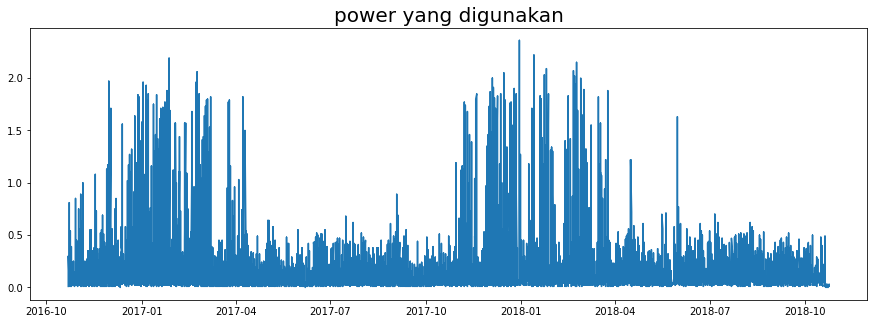

In [16]:
#membuat plot data berdasarkan date dan tegangan
import matplotlib.pyplot as plt
date  = df['DATE'].values
power  = df['USAGE'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(date,power)
plt.title('power yang digunakan',
          fontsize=20);
#Author : Sarah Salsabila (https://github.com/sarahsalsabila01)

In [17]:
#membagi validasi data 20%
from sklearn.model_selection import train_test_split

power_train, power_test, date_train, date_test = train_test_split(power, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(power_train), len(power_test))

56294 14074


In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
data_power_train = windowed_dataset(power_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_power_test = windowed_dataset(power_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [21]:
#membuat callback 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')is not None and logs.get('mae') <= batas_mae):
      print("\n Mae nya sudah dibawah ", batas_mae , ", training data dihentikan !")
      self.model.stop_training = True

callbacks = myCallback()

In [22]:
#optimizer dan menggunakan learning rate
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
#melakukan model fit .
#tidak menyertakan callback agar sesuai dengan review notes . harus mencapai nilai terbaik untuk pendekatan kekasus yang lebih baik
history = model.fit(data_power_train,
                    epochs=30,
                    validation_data=data_power_test)
#Author : Sarah Salsabila (https://github.com/sarahsalsabila01)

Epoch 1/30
563/563 [==============================] - 36s 46ms/step - loss: 0.0263 - mae: 0.1022 - val_loss: 0.0049 - val_mae: 0.0658
Epoch 2/30
563/563 [==============================] - 25s 42ms/step - loss: 0.0235 - mae: 0.1111 - val_loss: 0.0048 - val_mae: 0.0723
Epoch 3/30
563/563 [==============================] - 25s 43ms/step - loss: 0.0230 - mae: 0.1147 - val_loss: 0.0048 - val_mae: 0.0742
Epoch 4/30
563/563 [==============================] - 25s 42ms/step - loss: 0.0228 - mae: 0.1156 - val_loss: 0.0048 - val_mae: 0.0746
Epoch 5/30
563/563 [==============================] - 25s 43ms/step - loss: 0.0226 - mae: 0.1153 - val_loss: 0.0048 - val_mae: 0.0745
Epoch 6/30
563/563 [==============================] - 25s 43ms/step - loss: 0.0225 - mae: 0.1152 - val_loss: 0.0047 - val_mae: 0.0744
Epoch 7/30
563/563 [==============================] - 25s 43ms/step - loss: 0.0224 - mae: 0.1150 - val_loss: 0.0047 - val_mae: 0.0745
Epoch 8/30
563/563 [==============================] - 25s 43ms

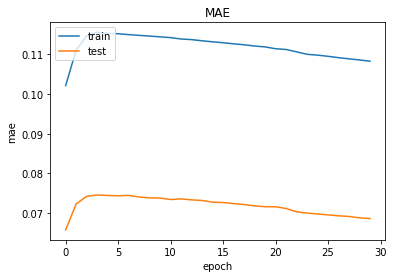

In [24]:
 # plot dari maenya
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

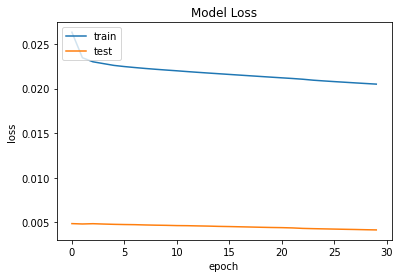

In [26]:
# plot dari lossnya
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#Author : Sarah Salsabila (https://github.com/sarahsalsabila01)